In [78]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [88]:
# Параметры
x_start, x_end = 0, np.pi
y_start, y_end = 0, 1
h = 0.01
max_iter = 2000

In [89]:
# Функции
u0_func = lambda x, y: np.sin(4 * x) * y * np.exp(-5 * y)
f = lambda x, y: -(9 * y - 10) * np.sin(4 * x) * np.exp(-5 * y)
phiB = lambda x: -np.sin(4 * x)
phiT = lambda x: -(4 / np.exp(5)) * np.sin(4 * x)

In [90]:
# Сетки
x_arr = np.arange(x_start + h/2, x_end - h/2, h)
y_arr = np.arange(y_start + h/2, y_end - h/2, h)
X, Y = np.meshgrid(x_arr, y_arr, indexing='ij')

In [91]:
# Инициализация
z_grid = u0_func(X, Y)
z_grid -= np.mean(z_grid)
lambda_min_n = 4
lambda_max_n = (4 / h**2) * (np.sin(np.pi * (x_arr.size - 1) * h / (2 * np.pi))**2 +
                              np.sin(np.pi * (y_arr.size - 1) * h / 2)**2) + 4
tau = 2 / (lambda_min_n + lambda_max_n)

In [92]:
rhs = f(X, Y)
rhs[:, 0] += phiB(x_arr) / h
rhs[:, -1] += phiT(x_arr) / h
rhs -= np.mean(rhs)

In [93]:
def op_LD(u):
    res = np.zeros_like(u)

    for i in range(1, len(x_arr)):
        for j in range(len(y_arr)):
            res[i, j] += (-u[i - 1, j]) / (h ** 2)

    for i in range(len(x_arr) - 1):
        for j in range(len(y_arr)):
            res[i, j] += (-u[i + 1, j]) / (h ** 2)

    for i in range(len(x_arr)):
        for j in range(1, len(y_arr)):
            res[i, j] += (-u[i, j - 1]) / (h ** 2)

    for i in range(len(x_arr)):
        for j in range(len(y_arr) - 1):
            res[i, j] += (-u[i, j + 1]) / (h ** 2)

    # Условие периодичности
    for j in range(len(y_arr)):
        res[0, j] += (-u[-1, j]) / (h ** 2)

    for j in range(len(y_arr)):
        res[-1, j] += (-u[0, j]) / (h ** 2)

    return res

In [94]:
def op_D(u):
    res = np.zeros_like(u)

    for i in range(1, len(x_arr)):
        for j in range(len(y_arr)):
            res[i, j] += 1 / (h ** 2)

    for i in range(len(x_arr) - 1):
        for j in range(len(y_arr)):
            res[i, j] += 1 / (h ** 2)

    for i in range(len(x_arr)):
        for j in range(1, len(y_arr)):
            res[i, j] += 1 / (h ** 2)

    for i in range(len(x_arr)):
        for j in range(len(y_arr) - 1):
            res[i, j] += 1 / (h ** 2)

    # Условие периодичности
    for j in range(len(y_arr)):
        res[0, j] += 1 / (h ** 2)

    for j in range(len(y_arr)):
        res[-1, j] += 1 / (h ** 2)

    return res

In [95]:
def jacob_method():
    u = np.zeros((len(x_arr), len(y_arr)))
    op_D_values = op_D(u)
    deviation_by_step = []

    for _ in tqdm(range(max_iter)):
        ldu = op_LD(u)

        # Векторное обновление
        # u = (1 / op_D_values) * (rhs - ldu)
        u = (rhs - ldu)/ op_D_values

        # Рассчитываем отклонение на текущем шаге
        deviation_by_step.append(np.max(np.abs(u - z_grid)))

    return u, deviation_by_step


In [96]:
# Решение методом Якоби
U, deviation_by_step = jacob_method()
U -= np.mean(U) 
deviation = np.abs(U - z_grid) 


100%|██████████| 2000/2000 [02:38<00:00, 12.59it/s]


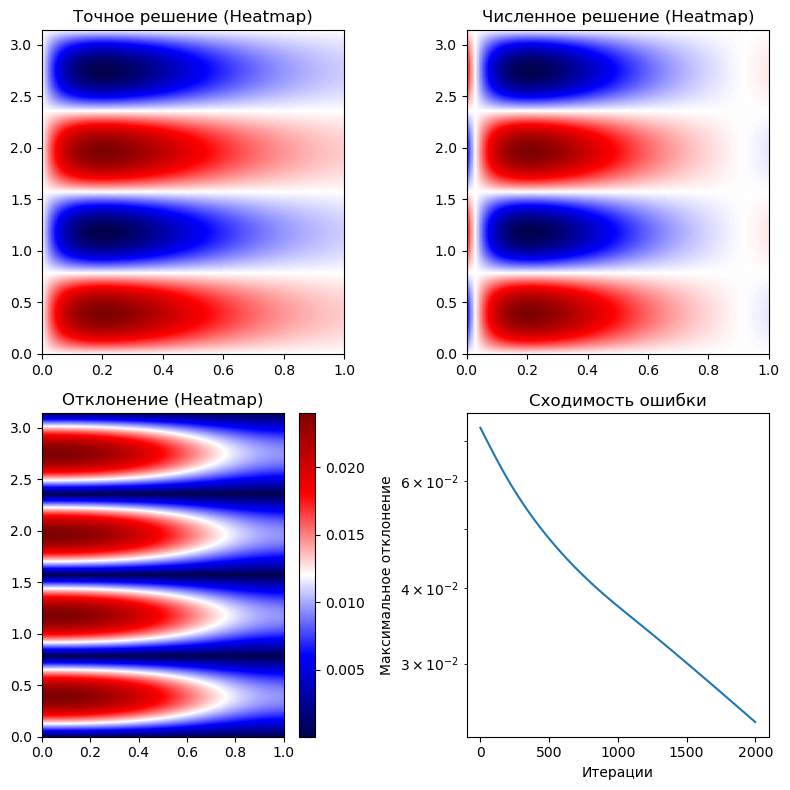

In [97]:
# Визуализация
fig = plt.figure(figsize=(8, 8))
# Тепловые карты
ax1 = fig.add_subplot(221)
ax1.imshow(z_grid, extent=[y_start, y_end, x_start, x_end], origin='lower', cmap='seismic', aspect='auto')
ax1.set_title("Точное решение (Heatmap)")

ax2 = fig.add_subplot(222)
ax2.imshow(U, extent=[y_start, y_end, x_start, x_end], origin='lower', cmap='seismic', aspect='auto')
ax2.set_title("Численное решение (Heatmap)")

ax4 = fig.add_subplot(223)
im1 = ax4.imshow(deviation, extent=[y_start, y_end, x_start, x_end], origin='lower', cmap='seismic', aspect='auto')
ax4.set_title("Отклонение (Heatmap)")
plt.colorbar(im1, ax = ax4, shrink = 1)
# # График сходимости
ax5 = fig.add_subplot(224)
ax5.plot(deviation_by_step)
ax5.set_yscale("log")
ax5.set_title("Сходимость ошибки")
ax5.set_xlabel("Итерации")
ax5.set_ylabel("Максимальное отклонение")

plt.tight_layout()
plt.show()